## This notebook implements a sample RNN for binary data and discusses the results
The code is taken from [here](https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html).

In [20]:
import numpy as np

print("Expected cross entropy loss if the model:")
print("- learns neither dependency:", -(0.625 * np.log(0.625) +
                                      0.375 * np.log(0.375)))
# Learns first dependency only ==> 0.51916669970720941
print("- learns first dependency:  ",
      -0.5 * (0.875 * np.log(0.875) + 0.125 * np.log(0.125))
      -0.5 * (0.625 * np.log(0.625) + 0.375 * np.log(0.375)))
print("- learns both dependencies: ", -0.50 * (0.75 * np.log(0.75) + 0.25 * np.log(0.25))
      - 0.25 * (2 * 0.50 * np.log (0.50)) - 0.25 * (0))

Expected cross entropy loss if the model:
- learns neither dependency: 0.661563238158
- learns first dependency:   0.519166699707
- learns both dependencies:  0.454454367449


In [1]:
import numpy as np
import tensorflow as tf
tf.reset_default_graph()
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Global config variables
num_steps = 10 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

In [3]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

## Model

In [4]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
RNN Inputs
"""

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

In [17]:
"""
Definition of rnn_cell

This is very similar to the __call__ method on Tensorflow's BasicRNNCell. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py#L95
"""
with tf.variable_scope('rnn_cell', reuse=True):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

In [18]:
"""
Adding rnn_cells to graph

This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
"""
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

In [19]:
"""
Predictions, loss, training step

Losses is similar to the "sequence_loss"
function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""

#logits and predictions
with tf.variable_scope('softmax', reuse=True):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# Turn our y placeholder into a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)

#losses and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

ValueError: Variable rnn_cell/W/Adagrad/ already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "<ipython-input-7-d65a9fa31e65>", line 22, in <module>
    train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)
  File "/home/atros/anaconda3/envs/aind-dl/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/atros/anaconda3/envs/aind-dl/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):


In [20]:
"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses

## With 2 Epochs and 10 steps for truncated back-prop


EPOCH 0
Average loss at step 100 for last 250 steps: 0.537628225982
Average loss at step 200 for last 250 steps: 0.522589657307
Average loss at step 300 for last 250 steps: 0.518897954822
Average loss at step 400 for last 250 steps: 0.519269860387

EPOCH 1
Average loss at step 100 for last 250 steps: 0.524979931116
Average loss at step 200 for last 250 steps: 0.517379146814
Average loss at step 300 for last 250 steps: 0.520136749446
Average loss at step 400 for last 250 steps: 0.5182605955


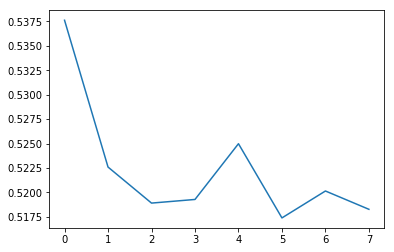

In [14]:
training_losses = train_network(2, num_steps)
plt.plot(training_losses)

## With 10 Epochs and 10 steps for truncated back-prop


EPOCH 0
Average loss at step 100 for last 250 steps: 0.572392495275
Average loss at step 200 for last 250 steps: 0.52105124712
Average loss at step 300 for last 250 steps: 0.515869947374
Average loss at step 400 for last 250 steps: 0.517551246285

EPOCH 1
Average loss at step 100 for last 250 steps: 0.52317329675
Average loss at step 200 for last 250 steps: 0.514584717751
Average loss at step 300 for last 250 steps: 0.513883838952
Average loss at step 400 for last 250 steps: 0.514756624401

EPOCH 2
Average loss at step 100 for last 250 steps: 0.52048327744
Average loss at step 200 for last 250 steps: 0.514103541374
Average loss at step 300 for last 250 steps: 0.515924432278
Average loss at step 400 for last 250 steps: 0.513075026572

EPOCH 3
Average loss at step 100 for last 250 steps: 0.518480090797
Average loss at step 200 for last 250 steps: 0.514532959759
Average loss at step 300 for last 250 steps: 0.51400372982
Average loss at step 400 for last 250 steps: 0.513225579262

EPOCH 4

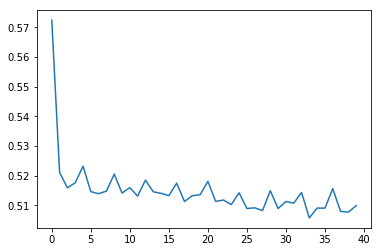

In [13]:
training_losses = train_network(10, num_steps)
plt.plot(training_losses)

## Implementation in TF API (static)

In [5]:
tf.reset_default_graph()

"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
Inputs
"""

x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

"""
RNN
"""

cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=init_state)

"""
Predictions, loss, training step
"""

with tf.variable_scope('softmax', reuse=None):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
    
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = tf.unstack(y, num=num_steps, axis=1)

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
          logit, label in zip(logits, y_as_list)]

total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [6]:
"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses


EPOCH 0
Average loss at step 100 for last 250 steps: 0.615081505775
Average loss at step 200 for last 250 steps: 0.52548915565
Average loss at step 300 for last 250 steps: 0.522556754351
Average loss at step 400 for last 250 steps: 0.521039970517

EPOCH 1
Average loss at step 100 for last 250 steps: 0.523448018134
Average loss at step 200 for last 250 steps: 0.518777176738
Average loss at step 300 for last 250 steps: 0.518765144348
Average loss at step 400 for last 250 steps: 0.517589893341


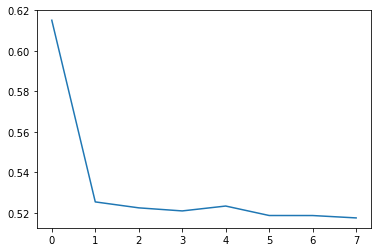

In [7]:
training_losses = train_network(2, num_steps)
plt.plot(training_losses)

## Final model in TF with DYNAMIC RNN

In [ ]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
Inputs
"""

rnn_inputs = tf.one_hot(x, num_classes)

"""
RNN
"""

cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

"""
Predictions, loss, training step
"""

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = tf.reshape(
            tf.matmul(tf.reshape(rnn_outputs, [-1, state_size]), W) + b,
            [batch_size, num_steps, num_classes])
predictions = tf.nn.softmax(logits)

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)